In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
from sklearn import tree
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score

In [2]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    
# Remove all NULLS in the Embarked column    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
# Remove all NULLS in the Age column
for dataset in full_data:
    dataset['Age'] = dataset['Age'].fillna(train['Age'].mean())
    
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;
    


In [4]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1.0,0,0,0,0,2,0,1
1,1,1,0,2.0,0,3,1,1,2,0,3
2,1,3,0,1.0,0,1,0,0,1,1,4
3,1,1,0,2.0,0,3,0,1,2,0,3
4,0,3,1,2.0,0,1,0,0,1,1,1


In [6]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2.0,0,0,2,0,1,1,1
1,3,0,2.0,0,0,0,0,2,0,3
2,2,1,3.0,0,1,2,0,1,1,1
3,3,1,1.0,0,1,0,0,1,1,1
4,3,0,1.0,1,1,0,0,3,0,3


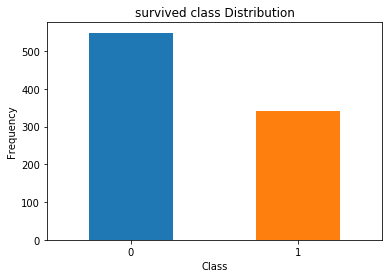

In [7]:
count_classes = pd.value_counts(train['Survived'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title('survived class Distribution')
plt.xticks(range(2))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [8]:
NoSurvived = len(train[train.Survived == 0])
Survived = len(train[train.Survived == 1])

print("Percentage of Passenger who didn't Survived: {:.2f}%".format((NoSurvived / (len(train.Survived))*100)))
print("Percentage of Passenger who survived: {:.2f}%".format((Survived / (len(train.Survived))*100)))

Percentage of Passenger who didn't Survived: 61.62%
Percentage of Passenger who survived: 38.38%


In [9]:
# Correlation Matrix

corr_matrix = train.corr()
corr_matrix

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
Survived,1.000000,-0.338481,-0.543351,-0.065770,0.081629,0.295875,0.106811,0.316912,0.016639,-0.203367,0.492031
Pclass,-0.338481,1.000000,0.131900,-0.112962,0.018443,-0.628459,0.045702,-0.725541,0.065997,0.135207,-0.165849
Sex,-0.543351,0.131900,1.000000,0.086111,-0.245489,-0.248940,-0.116569,-0.140391,-0.200988,0.303646,-0.859084
Age,-0.065770,-0.112962,0.086111,1.000000,-0.041678,0.022975,0.038244,0.085919,-0.065298,0.061521,-0.063509
Parch,0.081629,0.018443,-0.245489,-0.041678,1.000000,0.393048,-0.078665,0.036987,0.783111,-0.583398,0.221987
Fare,0.295875,-0.628459,-0.248940,0.022975,0.393048,1.000000,-0.091096,0.497108,0.465815,-0.568942,0.252631
Embarked,0.106811,0.045702,-0.116569,0.038244,-0.078665,-0.091096,1.000000,0.013774,-0.080281,0.017807,0.142480
Has_Cabin,0.316912,-0.725541,-0.140391,0.085919,0.036987,0.497108,0.013774,1.000000,-0.009175,-0.158029,0.138106
FamilySize,0.016639,0.065997,-0.200988,-0.065298,0.783111,0.465815,-0.080281,-0.009175,1.000000,-0.690922,0.213570
IsAlone,-0.203367,0.135207,0.303646,0.061521,-0.583398,-0.568942,0.017807,-0.158029,-0.690922,1.000000,-0.259345


In [10]:
y = train.Survived.values
x = train.drop(['Survived'], axis = 1)
print(x.shape)
print(y.shape)

(891, 10)
(891,)


In [11]:
# Initialise the Scaler 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
x = scaler.fit_transform(x)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
# Splitting the Data set in training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))


0.820627802690583


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
model2 = rf.fit(x_train, y_train)
y_pred = model2.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.8295964125560538


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
predictions = model2.predict(test)
submissions=pd.DataFrame({"PassengerId": PassengerId,
                         "Survived": predictions})
submissions.to_csv("submission.csv", index=False, header=True)

In [20]:
submissions

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0
